## Семинар 2 "Распознавание рукописных цифр"

ФИО: Полыковский Даниил Александрович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import Tensor
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

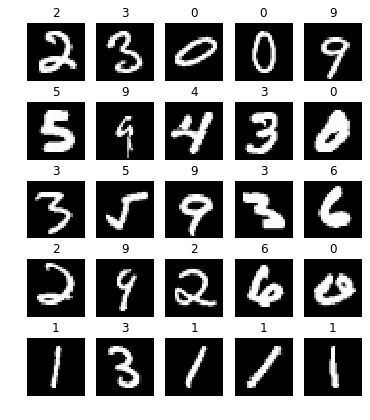

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, extra_batch=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    train_loader = []
    if extra_batch:
        train_loader = DataLoader(train_dataset + [(Tensor(extra_batch[0][i]), extra_batch[1][i])
                                                   for i in range(extra_batch[1].shape[0])], 
                                  batch_size=32, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 9... (Train/Test) NLL: 0.059/0.103	Accuracy: 0.984/0.969

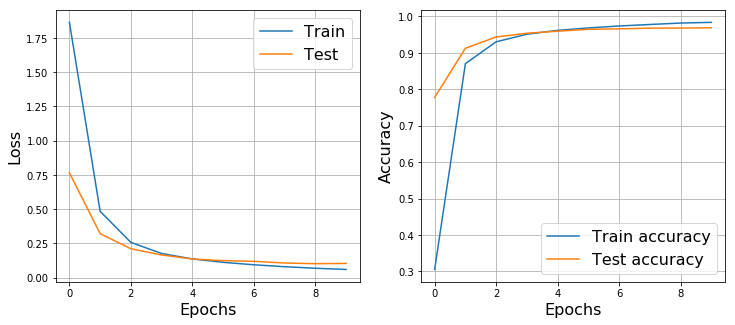

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 10, 0.1)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 9... (Train/Test) NLL: 0.018/0.087	Accuracy: 0.994/0.978

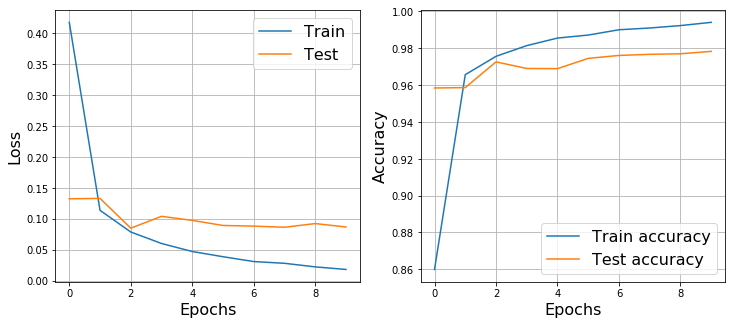

In [10]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.1, plot=True, verbose=True)

Epoch 9... (Train/Test) NLL: 0.015/0.124	Accuracy: 0.995/0.974

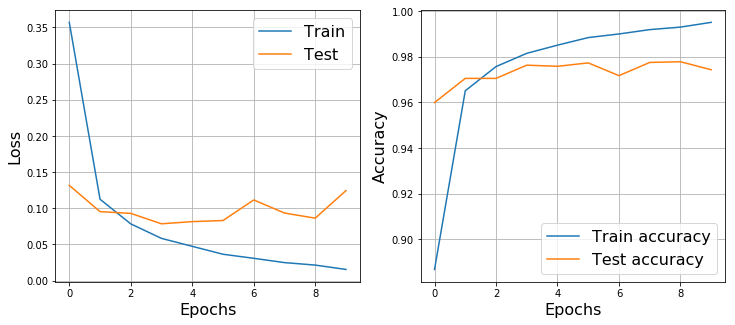

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.1, plot=True, verbose=True)

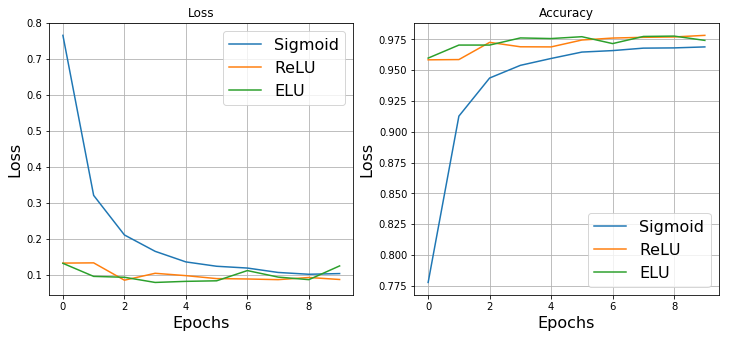

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [13]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        s = np.exp(2 * X)
        self.Y = (s - 1.) / (s + 1.)
        return self.Y
    
    def backward(self, dLdy):
        s = np.exp(2 * self.X)
        self.dLdx = dLdy * 4. * s / (s + 1.) ** 2
        return self.dLdx
    
    def step(self, learning_rate):
        pass

### Часть 3: Анализ ошибок

In [14]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

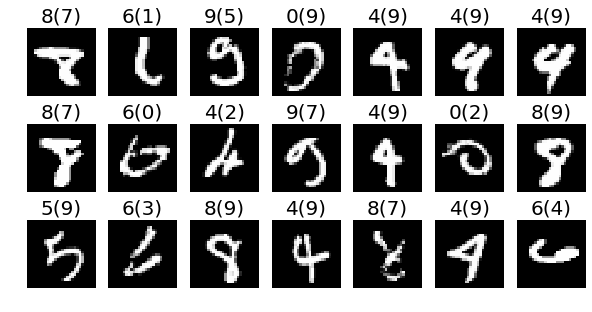

In [15]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]],
                              predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

In [16]:
Tensor(wrong_X[0].reshape(1, 28, 28)).size()

torch.Size([1, 28, 28])

In [17]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Epoch 9... (Train/Test) NLL: 0.016/0.081	Accuracy: 0.995/0.978

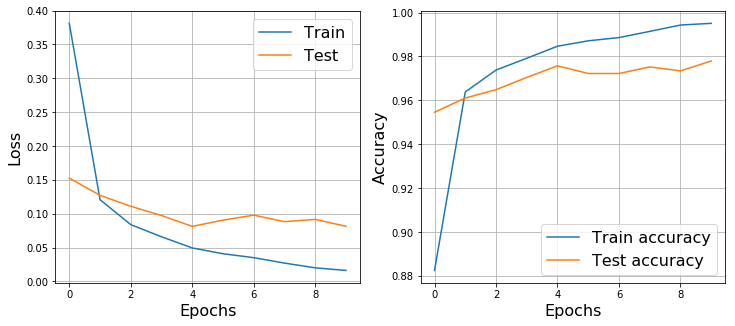

In [18]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])

tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 10, 0.1)

In [19]:
from skimage.transform import rotate
import copy
import random
random.seed(555)

In [20]:
def imrotate(batch, max_angle=15):
    images = copy.deepcopy(batch.reshape(-1, 28, 28))
    for i in range(images.shape[0]):
        images[i] = rotate(images[i], random.randint(-max_angle, max_angle))
    return images.reshape(-1, 28, 28)

def imshift(batch, shift=3, sight='left'):
    images = copy.deepcopy(batch.reshape(-1, 28, 28))
    if sight == 'left':
        for j in range(images.shape[0]):
            for i in range(images[j].shape[1] - shift):
                images[j][:, i] = images[j][:, i + shift]
            for i in range(-2, -shift - 1, -1):
                images[j][:, i] = images[j][:, -1]

            for i in range(images[j].shape[0] - shift):
                images[j][i, :] = images[j][i + shift, :]
            for i in range(-2, -shift - 1, -1):
                images[j][i, :] = images[j][-1, :]
                
    elif sight == 'right':
        for j in range(len(images)):
            for i in range(1, images[j].shape[1] - shift + 1):
                images[j][:, len(images) - i] = images[j][:, len(images) - i - shift]
            for i in range(1, shift):
                images[j][:, i] = images[j][:, 0]

            for i in range(images[j].shape[0] - shift):
                images[j][i, :] = images[j][i + shift, :]
            for i in range(-2, -shift - 1, -1):
                images[j][i, :] = images[j][-1, :]
    return images.reshape(-1, 28, 28)

def imnoise(batch, coef=0.1):
    images = copy.deepcopy(batch.reshape(-1, 28, 28))
    for j in range(len(images)):
        images[j] = images[j] + np.random.randn(28, 28) * coef
    return images.reshape(-1, 28, 28)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

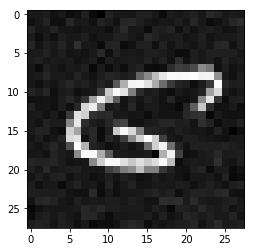

In [22]:
batch = imnoise(wrong_X)
plt.imshow(batch[30].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.017/0.043	Accuracy: 0.995/0.987

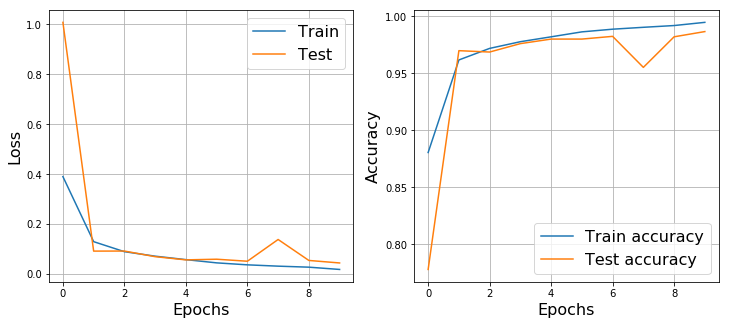

In [23]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
batch = batch.reshape(-1, 1, 28, 28)
tr_t_n, ts_t_n, tr_ac_t_n, ts_ac_t_n = train(network, 10, 0.1, extra_batch=(batch, correct_y))

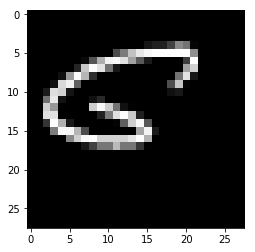

In [24]:
batch = imshift(wrong_X)
plt.imshow(batch[30].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.020/0.093	Accuracy: 0.994/0.975

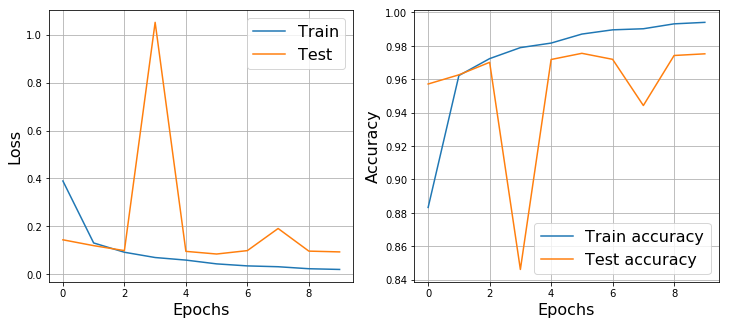

In [25]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
batch = batch.reshape(-1, 1, 28, 28)
tr_t_s, ts_t_s, tr_ac_t_s, ts_ac_t_s = train(network, 10, 0.1, extra_batch=(batch, correct_y))

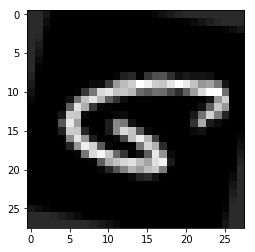

In [26]:
batch = imrotate(wrong_X)
plt.imshow(batch[30].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.018/0.063	Accuracy: 0.995/0.981

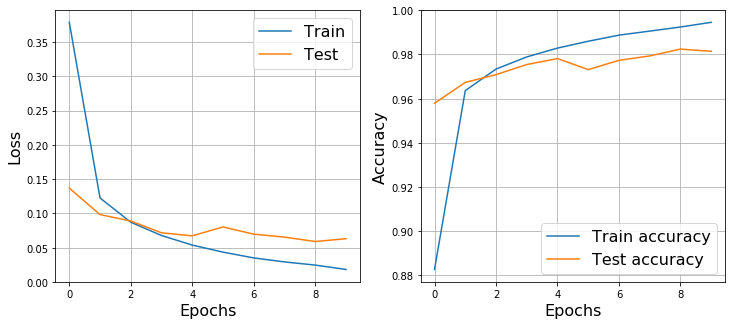

In [27]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
batch = batch.reshape(-1, 1, 28, 28)
tr_t_r, ts_t_r, tr_ac_t_r, ts_ac_t_r = train(network, 10, 0.1, extra_batch=(batch, correct_y))

Аугментация каждого вида по отдельности на данных, на которых модель ошибается, весомого прироста не дала (хотя нормальный шум немного улучшил картину). Попробуем объединить все виды аугментации.

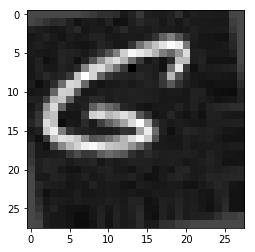

In [28]:
batch = imrotate(imshift(imnoise(wrong_X)))
plt.imshow(batch[30].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 19... (Train/Test) NLL: 0.002/0.085	Accuracy: 1.000/0.979

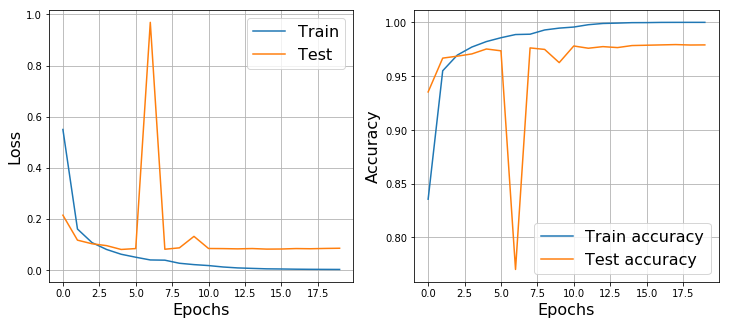

In [29]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
batch = batch.reshape(-1, 1, 28, 28)
tr_t_a, ts_t_a, tr_ac_t_a, ts_ac_t_a = train(network, 20, 0.05, extra_batch=(batch, correct_y))

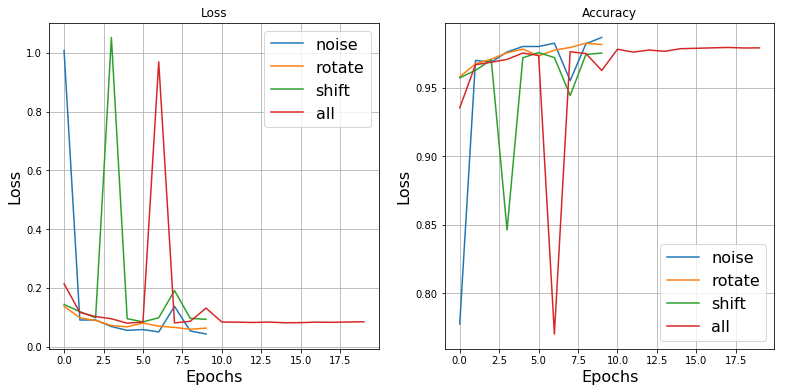

In [30]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_t_n, label='noise')
plt.plot(ts_t_r, label='rotate')
plt.plot(ts_t_s, label='shift')
plt.plot(ts_t_a, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_t_n, label='noise')
plt.plot(ts_ac_t_r, label='rotate')
plt.plot(ts_ac_t_s, label='shift')
plt.plot(ts_ac_t_a, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Выбить результат лучше не удается, модель успевает только переобучиться.

В итоге лучший результат на тесте показала аугментация с нормальным шумом.

Проведем те же махинации для ELU, Sigmoid и ReLU.

Epoch 9... (Train/Test) NLL: 0.021/0.093	Accuracy: 0.993/0.978

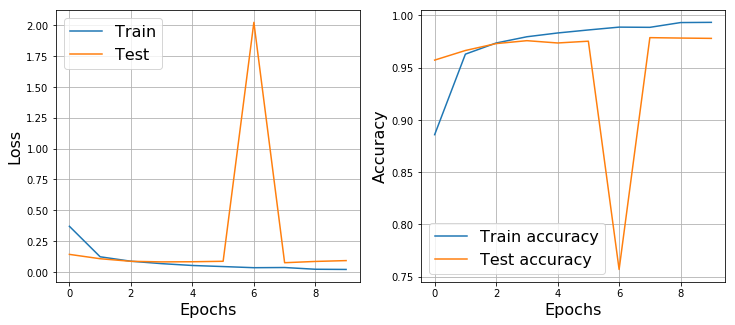

In [31]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
batch = batch.reshape(-1, 1, 28, 28)
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.1, plot=True, verbose=True, extra_batch=(batch, correct_y))

Epoch 9... (Train/Test) NLL: 0.064/0.090	Accuracy: 0.983/0.972

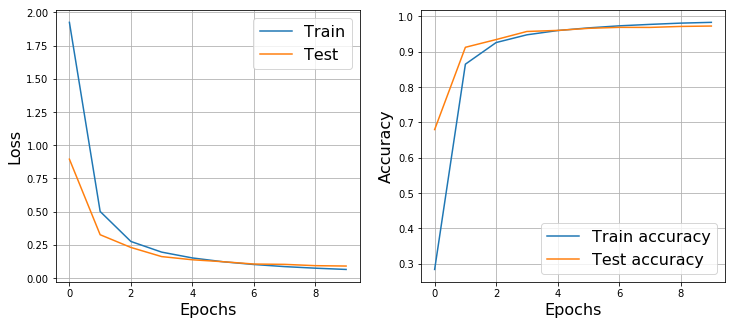

In [32]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)])
loss = NLLLoss()
batch = batch.reshape(-1, 1, 28, 28)
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 10, 0.1, plot=True, verbose=True, extra_batch=(batch, correct_y))

Epoch 9... (Train/Test) NLL: 0.022/0.083	Accuracy: 0.993/0.978

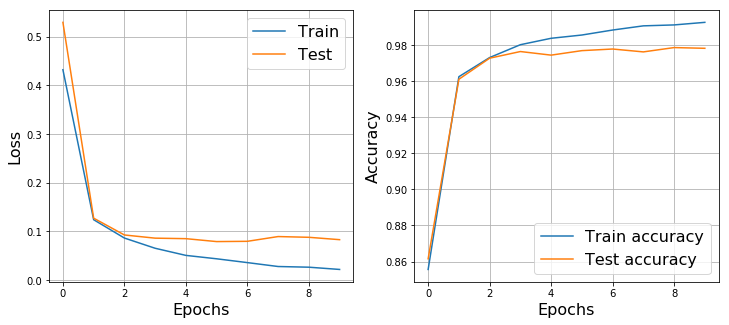

In [33]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
batch = batch.reshape(-1, 1, 28, 28)
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.1, plot=True, verbose=True, extra_batch=(batch, correct_y))

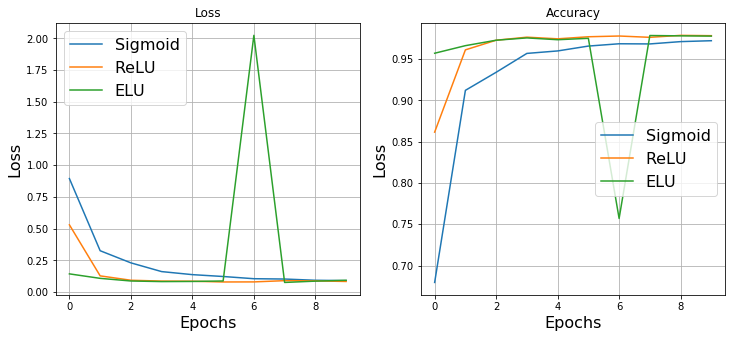

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сравнивая результаты обучения, можно сделать вывод, что нелинейность влияет на сходимость (лучший результат на test показал гиперболический тангенс). Использование аугментации в виде нормального шума для той же нелинейности выдало по итогу лучший результат 0.044 на test, что лучше многих полученных результатов почти в 2 раза. Композиция аугментаций не дала прироста эффективности классификации ни для одной нелинейности. Для гиперболического тангенса композиция аугментаций ко всему прочему переобучила сеть.

Итак, можно сделать вывод, что выбор нелинейности и предобработка данных существенно влияет на результаты обучения.